## Z_N HC code

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, List, Dict, Any, Set, FrozenSet, Iterable, Tuple
import math
import random
import networkx as nx
import sympy as sym

import os
import galois

Lets outline how to represent everything:

* Coordinate system: (a+jb) is down b steps and right a steps


* Logicals: can be represented as 2*dataqubits vector (Xs on all data qubits|Z on all data qubits) this lives in the final time slice

* Error string: this can be pushed through to the final time step so we can check commutation with the logical:
1. use decoder to get errors on each data qubit. 
2. X error on qubit n in the final round will be sum of all the X errors on n throughout time. Note these only correspond to errors after blue plaquette inferences.

### Details of what we need for this

In [21]:
EDGES_AROUND_HEX: List[Tuple[complex, complex]] = [
    (-1 - 1j, +1 - 1j),
    (+1 - 1j, +1),
    (+1, +1 + 1j),
    (+1 + 1j, -1 + 1j),
    (-1 + 1j, -1),
    (-1, -1 - 1j),
]


def torus(c: complex, distance: int) -> complex:
    """Apply toroidal topology to a point on the lattice."""
    r = c.real % (distance * 4)
    i = c.imag % (distance * 6)
    return r + i*1j

def sorted_complex(xs: Iterable[complex]) -> List[complex]:
    """Sort a list of complex numbers."""
    return sorted(xs, key=lambda v: (v.real, v.imag))

def int_to_pauli(i: int) -> str:
    """Convert an integer to a Pauli operator."""
    pauli_dict = {0: "X", 1: "Y", 2: "Z"}
    if i not in pauli_dict:
        raise ValueError('Integer must be 0, 1, or 2')
    return pauli_dict[i]

######### Plaquette functions    

def initialize_hex_centers(distance: int) -> Dict[complex, int]:
    """Initialize the hex centers on the lattice."""
    hex_centers = {}
    for row in range(3 * distance):
        for col in range(2 * distance):
            center = row * 2j + 2 * col - 1j * (col % 2)
            category = (-row - col % 2) % 3
            hex_centers[torus(center, distance=distance)] = category
    return hex_centers

def categorize_hexes(hex_centers: Dict[complex, int]) -> Tuple[List[complex], List[complex], List[complex]]:
    """Categorize hexes into red, green, and blue."""
    red_hexes = [h for h, category in hex_centers.items() if category == 0]
    green_hexes = [h for h, category in hex_centers.items() if category == 1]
    blue_hexes = [h for h, category in hex_centers.items() if category == 2]
    return red_hexes, green_hexes, blue_hexes

def get_rgb_hexes(distance: int) -> Tuple[List[complex], List[complex], List[complex]]:
    """Get the red, green, and blue hexes."""
    hex_centers = initialize_hex_centers(distance=distance)
    red_hexes, green_hexes, blue_hexes = categorize_hexes(hex_centers=hex_centers)
    return red_hexes, green_hexes, blue_hexes

##### qubit functions
def qubits_in_plaquettes(d):
    QUBITS_AROUND_HEX = [
        (-1 - 1j), #TL
        (+1 - 1j), #TR
        (+1),      #R
        (+1 + 1j), #BR
        (-1 + 1j), #BL
        (-1)       #L
    ]
    hexes = initialize_hex_centers(d)
    qubit_dictionary = {}
    for hex in hexes:
        qubit_coordinates = []
        for qubit in QUBITS_AROUND_HEX:
            q = hex + qubit
            qubit_coordinates.append(torus(q,d))

        qubit_dictionary[hex] = qubit_coordinates

    return qubit_dictionary

def qubits(d):
    qubits_set = set()
    for p in get_rgb_hexes(d)[0]:
        for q in qubits_in_plaquettes(d)[p]:
            qubits_set.add(q)

    return sorted_complex(list(qubits_set))

def qubits_to_plaq(d): # returns dic D: D[q] = [pos R, pos G, pos B]
    qubits_= {}
    qubits_in_plaq= qubits_in_plaquettes(d)
    r,g,b = get_rgb_hexes(d)
    for qubit in qubits(d):
        qubits_in_plaq[qubit] = []
        
        for c in [r,g,b]:
            for plaq in c:
                if overlap(set(qubits_in_plaq[plaq]), {qubit}):
                    qubits_in_plaq[qubit].append(plaq)
    return qubits_in_plaq


##### edge functions
EDGES_AROUND_HEX: List[Tuple[complex, complex]] = [
    (-1 - 1j, +1 - 1j), #top T
    (+1 - 1j, +1), #top right TR
    (+1, +1 + 1j), #bottom right BR
    (+1 + 1j, -1 + 1j), # bottom B
    (-1 + 1j, -1), #bottom left BL
    (-1, -1 - 1j), # top left TL
]

edge_dictionary ={}
for i, edge in enumerate(['T', 'TR', 'BR', 'B', 'BL', 'TL']):
    edge_dictionary[edge] = EDGES_AROUND_HEX[i]

# use fig 1 of https://arxiv.org/pdf/2108.10457.pdf
# left create dictionary between -> (edge, color)

def get_rgb_edges(d):
    r,g,b = get_rgb_hexes(d)
    r_edges, g_edges, b_edges = [[],[],[]]
    edge_translation = lambda h,edge: (torus(h+edge[0], d), torus(h+edge[1],d))

    # edge = {(qubit_0, qubit_1), pauli_type, (error_0, error_1), color}
    for plaq in r:
        b_edges.append({'qubits':edge_translation(plaq, edge_dictionary['T']),'type': 'Z', 'error type': ('X', 'Y'), 'color': 'b'})
        b_edges.append({'qubits':edge_translation(plaq, edge_dictionary['BR']),'type': 'X', 'error type': ('Y', 'Z'), 'color': 'b'})
        b_edges.append({'qubits':edge_translation(plaq, edge_dictionary['BL']),'type': 'Y', 'error type': ('Z', 'X'), 'color': 'b'})

    for plaq in g:
        r_edges.append({'qubits':edge_translation(plaq, edge_dictionary['T']),'type': 'Z', 'error type': ('X', 'Y'), 'color': 'r'})
        r_edges.append({'qubits':edge_translation(plaq, edge_dictionary['BR']),'type': 'X', 'error type': ('Y', 'Z'), 'color': 'r'})
        r_edges.append({'qubits':edge_translation(plaq, edge_dictionary['BL']),'type': 'Y', 'error type': ('Z', 'X'), 'color': 'r'})

    for plaq in b:
        g_edges.append({'qubits':edge_translation(plaq, edge_dictionary['T']),'type': 'Z', 'error type': ('X', 'Y'), 'color': 'g'})
        g_edges.append({'qubits':edge_translation(plaq, edge_dictionary['BR']),'type': 'X', 'error type': ('Y', 'Z'),'color': 'g'})
        g_edges.append({'qubits':edge_translation(plaq, edge_dictionary['BL']),'type': 'Y', 'error type': ('Z', 'X'),'color': 'g'})
        

    return r_edges, g_edges, b_edges

def overlap(qubits1: set, qubits2: set): #checks if two lists of qubits around plaquettes overlap
    share_qubit = False
    if not qubits1.isdisjoint(qubits2):
        share_qubit=True
    return share_qubit

def tuple_diff(p:Tuple, e:Tuple):
    x = (p[0] - e[0]) 
    y = (p[1] - e[1])
    t = (p[2]-p[2])

    return (x,y,t)

def graph_inverse(dic, property, property_val):
    key = 0
    for keys in dic:
        if dic[keys][property] == property_val:
            key = keys
    return key


def comm_dict(q):
    dic= {}
    dic['X', 'Y'] = 1
    dic['X', 'Z'] = q-1
    dic['Y','X'] = q-1
    dic['Y','Z'] = 1
    dic['Z','Y'] = q-1
    dic['Z', 'X'] = 1

    return dic
######################
#error models

def depolarized_noise(p): #for now just allow X errors, not X^n
    error = {'X': 0, 'Y': 0, 'Z': 0}

    rand_val = np.random.random()
    if rand_val<p/3:
        error['X'] = 1
    elif p/3<rand_val<2*p/3:
        error['Y'] = 1
    elif 2*p/3 < rand_val < p/3:
        error['Z'] = 1
    
    return error


#####


## Now that we have all these useful functions, lets define a class

In [22]:
class HC_code():
    def __init__(self, distance, depth, qubit_dim):
        self.distance = distance
        self.q = qubit_dim
        self.depth = depth

        # Now lets get a bunches of data structures relating things eg (plaq->qubits, edges->qubits etc)

        # r,g and b plaquette coordinates
        self.r_xy, self.g_xy, self.b_xy = get_rgb_hexes(self.distance)
        self.comm_relations = comm_dict(self.q) #dictionary for commutation realtions

        # qubit coordinates
        qubits_set = set()
        for p in self.r_xy:
            for q in qubits_in_plaquettes(self.distance)[p]:
                qubits_set.add(q)

        self.qubits = sorted_complex(list(qubits_set)) # list of all data qubit
        
        #dictionary plaq coord->qubit around plaquette coord
        self.plaq_to_qubit = qubits_in_plaquettes(self.distance)

        #dictionary qubit coord -> surrounding plaq [R,G,B] coord
        self.qubit_to_plaq = qubits_to_plaq(self.distance)
        # need function for all qubits

        #r,g and b edges
        self.r_edges, self.g_edges, self.b_edges = get_rgb_edges(self.distance)
    
    def make_tanner_graph(self):
        T = nx.Graph()

        self.R_nodes,self.G_nodes,self.B_nodes = [[],[],[]]
        self.stabilizer_nodes = []

        # add plaq nodes
        plaq_node_counter = 0
        for t in range(self.depth):
            for plaq_node in self.r_xy:
                T.add_node(plaq_node_counter, pos = (plaq_node.real, plaq_node.imag, 3*t), color = 'r', xy = plaq_node) # add node
                self.R_nodes.append(plaq_node_counter) #store in color list
                self.stabilizer_nodes.append(plaq_node_counter) #store in all plaq list
                plaq_node_counter+=1


            for plaq_node in self.g_xy:
                T.add_node(plaq_node_counter, pos = (plaq_node.real, plaq_node.imag, 3*t+1), color = 'g', xy = plaq_node)
                self.G_nodes.append(plaq_node_counter)
                self.stabilizer_nodes.append(plaq_node_counter)
                plaq_node_counter+=1


            for plaq_node in self.b_xy:
                T.add_node(plaq_node_counter, pos = (plaq_node.real, plaq_node.imag, 3*t+2), color = 'b', xy = plaq_node)
                self.B_nodes.append(plaq_node_counter)
                self.stabilizer_nodes.append(plaq_node_counter)
                plaq_node_counter+=1

        ##add one more layer of red
        for plaq_node in self.r_xy:
                T.add_node(plaq_node_counter, pos = (plaq_node.real, plaq_node.imag, 3*self.depth), color = 'rx', xy = plaq_node) # add node
                self.R_nodes.append(plaq_node_counter) #store in color list
                self.stabilizer_nodes.append(plaq_node_counter) #store in all plaq list
                plaq_node_counter+=1

################################################
        #### add data nodes
        data_node_counter,t = [-1, 0] #data nodes < 0
        self.data_nodes = []
        
        while t < 3*self.depth+1: # generate all but final layer of data qubits
            for c_edges in [self.b_edges,self.r_edges,self.g_edges]:
                for edge in c_edges:
                    qubits_pos = edge['qubits'] #(qubit0, qubit1)
                    error_type = edge['error type'] #('sigma0', 'sigma1')
                    color_type = edge['color']
                    edge_type = edge['type'] # need this to work out commutation relation for parity check matrix

                    for i in [0,1]:
                        T.add_node(data_node_counter, pos = (qubits_pos[i].real, qubits_pos[i].imag, t+1/2), error = error_type[i], xy = qubits_pos[i], color = color_type, edge_before = edge_type)
                        self.data_nodes.append(data_node_counter)
                        data_node_counter-=1
                t+=1
        
        #for c_edges in [self.b_edges,self.r_edges]: #last layers doesnt have data qubits for penultimate blue plaq layers or final red plaq layer
            #for edge in c_edges:
                #qubits_pos = edge['qubits'] #(qubit0, qubit1)
                #error_type = edge['error type'] #('sigma0', 'sigma1')
                #color_type = edge['color'] 
                #edge_type = edge['type'] # need this to work out commutation relation for parity check matrix

                #for i in [0,1]:
                    #T.add_node(data_node_counter, pos = (qubits_pos[i].real, qubits_pos[i].imag, t+1/2), error = error_type[i], xy = qubits_pos[i], color = color_type, edge_before = edge_type)
                    #self.data_nodes.append(data_node_counter)
                    #data_node_counter-=1
            #t+=1  

################################################
        # now add edges
        for data_node in self.data_nodes:
            t, xy_data, color = [T.nodes[data_node]['pos'][2], T.nodes[data_node]['xy'], T.nodes[data_node]['color']]
            r_coord, g_coord, b_coord = self.qubit_to_plaq[xy_data]

            parity_entry = self.comm_relations[T.nodes[data_node]['error'],T.nodes[data_node]['edge_before']]
            #RB 
            if color == 'b':
                r_node = graph_inverse(T.nodes, 'pos', (r_coord.real, r_coord.imag, t-1/2))
                T.add_edge(r_node, data_node, label = T.nodes[data_node]['error'], parity = parity_entry)

                b_node = graph_inverse(T.nodes, 'pos', (b_coord.real, b_coord.imag, t+1+1/2))
                T.add_edge(b_node, data_node, label = T.nodes[data_node]['error'], parity = -parity_entry % self.q) # might have to fix this when we use galois
            
            if color == 'g':
                b_node = graph_inverse(T.nodes, 'pos', (b_coord.real, b_coord.imag, t-1/2))
                T.add_edge(b_node, data_node, label = T.nodes[data_node]['error'], parity = parity_entry)

                if t<3*self.depth-1:

                    g_node = graph_inverse(T.nodes, 'pos', (g_coord.real, g_coord.imag, t+1+1/2))
                    T.add_edge(g_node, data_node, label = T.nodes[data_node]['error'], parity = -parity_entry % self.q)

            if color == 'r':
                g_node = graph_inverse(T.nodes, 'pos', (g_coord.real, g_coord.imag, t-1/2))
                T.add_edge(g_node, data_node, label = T.nodes[data_node]['error'], parity = parity_entry)

                r_node = graph_inverse(T.nodes, 'pos', (r_coord.real, r_coord.imag, t+1+1/2))
                T.add_edge(r_node, data_node, label = T.nodes[data_node]['error'], parity = -parity_entry % self.q)

        self.T = T

        ### make parity check matrix
    def make_H(self):
        self.H = np.zeros((len(self.R_nodes+self.G_nodes+self.B_nodes), len(self.data_nodes)),dtype = int)
        for u,v in self.T.edges():
            self.H[u,-v-1]=self.T.edges[(u,v)]['parity']



        ### We will need dictionaries relating data_nodes corresponding to the same physical qubit
        self.qubits_over_time = {} # dic[node at t0] = [(node at t = n, sigma at t= n)] where all the nodes are on same physical site
        for node in self.data_nodes[0:len(self.qubits)]:
            self.qubits_over_time[node] = []
            xy = self.T.nodes[node]['xy']

            for later_nodes in self.data_nodes:
                if self.T.nodes[later_nodes]['xy'] == xy:
                    self.qubits_over_time[node].append((later_nodes, self.T.nodes[later_nodes]['error']))

    def physical_error(self, p): # assuming depolarized noise for now

        self.E_phys = np.zeros(len(self.data_nodes), dtype = int)

        for initial_node in self.qubits_over_time:
            temp_dic = self.qubits_over_time[initial_node]

            for t in range(1,3*self.depth-2): ######### fix this so we have errors in first and last layer. As is its only 2nd through n-1 th
                sigma_before, sigma_now, sigma_after = [temp_dic[t-1][1], temp_dic[t][1], temp_dic[t+1][1]] 
                e = depolarized_noise(p)
                
                self.E_phys[-temp_dic[t][0]-1] += e[sigma_before] - e[sigma_after] #mod q
                self.E_phys[-temp_dic[t+1][0]-1] += e[sigma_now] - e[sigma_after] #mod q

                self.E_phys = self.E_phys % self.q

            #next add measurement error
    def measurement_error(self,p):
        self.node_errors_measurement = {}
        for node in self.data_nodes:
            self.node_errors_measurement[node] = {'X': 0, 'Y': 0, 'Z':0}

        for key in self.qubits_over_time: # key is qubit(node) at t=0 for each site
            for n, node_and_pauli in enumerate(self.qubits_over_time[key]):# node = node_and_pauli[0] and sigma = node_and_pauli[1]
                if np.random.rand()<p and n < len(self.qubits_over_time[key])-1:
                    # measurement error is equivalent to sigma at t and sigma^dagger at t+1
                    self.node_errors_measurement[node_and_pauli[0]][node_and_pauli[1]] += 1
                    self.node_errors_measurement[self.qubits_over_time[key][n+1][0]][node_and_pauli[1]] -= 1 #self.qubits_over_time[key][n+1][0] gives next node in time

        ### Now we populate error vector with data from node_errors_measurement
        ########### FINISH THIS
        self.E_meas = np.zeros(len(self.data_nodes), dtype = int)

        for initial_node in self.qubits_over_time:
            temp_dic = self.qubits_over_time[initial_node]

            for t in range(1,3*self.depth-2): ######### fix this so we have errors in first and last layer. As is its only 2nd through n-1 th
                sigma_before, sigma_now, sigma_after = [temp_dic[t-1][1], temp_dic[t][1], temp_dic[t+1][1]] 
               
                #E_meas[node] = node_error_measure[node][sigma of previous node] - node_error_measure[node][sigma of next node]
                self.E_meas[-temp_dic[t][0]-1] += self.node_errors_measurement[temp_dic[t][0]][sigma_before] - self.node_errors_measurement[temp_dic[t][0]][sigma_after]#mod q
                self.E_meas[-temp_dic[t+1][0]-1] += self.node_errors_measurement[temp_dic[t][0]][sigma_now] - self.node_errors_measurement[temp_dic[t][0]][sigma_after]#mod q
                
                self.E_meas = self.E_meas % self.q



    def make_error(self,p, meas = True):
        self.physical_error(p)
        self.measurement_error(p)

        self.E = self.E_phys+self.E_meas

        if meas == False:
            self.E = self.E_phys
        
        self.E = self.E % self.q


    def final_pauli(self, correction): #take error+correction and convert it to product of pauli's in the final layer
        self.errors_on_sites = {}
        for i, site in enumerate(self.qubits):
            self.errors_on_sites[site] = {'X': 0, 'Y': 0, 'Z':0} # errors in each site, key is site position
        
        # Now add in errors from correction 
        for key in self.qubits_over_time: # key is qubit(node) at t=0 for each site
            site_pos = self.T.nodes[key]['xy']

            for node_and_pauli in self.qubits_over_time[key]: # node = node_and_pauli[0] and sigma = node_and_pauli[1].
                self.errors_on_sites[site_pos][node_and_pauli[1]] += self.E[-node_and_pauli[0]-1] - correction[-node_and_pauli[0]-1]


        # now let's make a |sites| x 2 dimentional matrix for X and Z types errors on the sites at the final timestep
        # this is object we will check commutation relations with
        self.error_XZ = np.zeros((2,len(self.qubits)), dtype = int) # self.error_XZ[0] = X-type errors and # self.error_XZ[1] = Z_type errors

        for i, site in enumerate(self.qubits): 
            self.error_XZ[0][i] = (self.errors_on_sites[site]['X'] + (self.q-1) * self.errors_on_sites[site]['Y']) % self.q # might have to changes this for Galois part
            self.error_XZ[1][i] = (self.errors_on_sites[site]['Z'] + (self.q-1) * self.errors_on_sites[site]['Y']) % self.q 


                

    ###### Fix logicals
    
    def logicals(self): # we always consider logical just after blue round (so red plaq just updated)
        
        self.v_sites: List[Tuple(complex, str)]=[] #(sites, paulis) in logical vertical logical, lives on green edges
        #for n in range(0, 6*self.distance, 6):
         #   self.v_sites.append((1+1j*((n+2)% (6*self.distance)), 'Z'))
          #  self.v_sites.append((1+1j*((n+3)% (6*self.distance)), 'X'))

           # self.v_sites.append((1+1j*((n+5)% (6*self.distance)), 'Z dag'))
            #self.v_sites.append((1+1j*((n+6)% (6*self.distance)), 'Y dag'))
        
        # em string
        for n in range(0, 6*self.distance, 2):
            self.v_sites.append((1+1j*((n+2)% (6*self.distance)), 'Z'))
            self.v_sites.append((1+1j*((n+3)% (6*self.distance)), 'Z dag'))

           

        self.h_sites: List[Tuple(complex, str)]=[] #(sites, paulis) in horizontal logical, lives on blue edges
        for n in range(1, 4*self.distance, 4):
            self.h_sites.append( ((n-2)% (4*self.distance) + 1j*(6*self.distance-1), 'Y'))
            self.h_sites.append( ((n)% (4*self.distance) + 1j*(6*self.distance-1), 'X'))


        site_to_index_dic = {}
        for i, site in enumerate(self.qubits):
            site_to_index_dic[site] = [i]



        ### now lets create vector for 
        
        self.L1v = np.zeros((2, len(self.qubits)), dtype = int) # L1v[0] = support of Z operators, L1v[1] = support of X operators
        self.L1h = np.zeros((2, len(self.qubits)), dtype = int)

        for site_pauli in self.v_sites: #site = site_pauli[0] and pauli = site_pauli[1]
            index = site_to_index_dic[site_pauli[0]] #index for the vector

            if site_pauli[1] == 'Y dag':
                self.L1v[1][index] += 1
                self.L1v[0][index] += 1
            elif site_pauli[1] == 'X':
                self.L1v[1][index] += 1
            elif site_pauli[1] == 'Z':
                self.L1v[0][index] += 1
            elif site_pauli[1] == 'Z dag':
                self.L1v[0][index] += -1
        
        for site_pauli in self.h_sites: #site = site_pauli[0] and pauli = site_pauli[1]
            index = site_to_index_dic[site_pauli[0]] #index for the vector

            if site_pauli[1] == 'Y':
                self.L1h[0][index] += -1
                self.L1h[1][index] += -1
            elif site_pauli[1] == 'X':
                self.L1h[1][index] += 1

        ### add second pair or logicals later
        self.L1v = self.L1v % self.q
        self.L1h = self.L1h % self.q
    
### trying to get parity check matrix in terms of qubits:
## ordering of the qubits is same as logical ops: done according to self.qubits 
            
    def parity_check_physical(self):
        plaq_counter = 0
        plaq_dic = {}
        
        #dic for index->xy
        for c_plaq in [self.r_xy,self.g_xy, self.b_xy]:
            for plaq in c_plaq:
                plaq_dic[plaq_counter] = plaq
                plaq_counter+=1

        #qubit dic for xy->index
        qubit_to_num_dic = {}
        for i, xy in enumerate(self.qubits):
            qubit_to_num_dic[xy] = i

        #dic plaq index -> [(qubit index, pauli of index)]
        self.plaq_qubit_pauli_dic = {}
        pauli_site = ['Y', 'X', 'Z', 'Y','X', 'Z']

        for n in range(plaq_counter):
            self.plaq_qubit_pauli_dic[n] = []
            qubits_xy = self.plaq_to_qubit[plaq_dic[n]]

            for q, qubit in enumerate(qubits_xy):
                self.plaq_qubit_pauli_dic[n].append((qubit_to_num_dic[qubit], pauli_site[q]))

        
        #define parity check matrix for Z and X parts
        self.HC_parity_check = np.zeros((2, plaq_counter, len(self.qubits))) #H[0] = X opps support and H[1] = Z ops support

        for n in range(plaq_counter):
            for site_pauli in self.plaq_qubit_pauli_dic[n]:
                if site_pauli[1] == 'Y':
                    self.HC_parity_check[0][n][site_pauli[0]] = -1
                    self.HC_parity_check[1][n][site_pauli[0]] = -1
                elif site_pauli[1] == 'X':
                    self.HC_parity_check[0][n][site_pauli[0]] = 1
                
                elif site_pauli[1] == 'Z':
                    self.HC_parity_check[1][n][site_pauli[0]] = 1

                


        self.HC_parity_check = self.HC_parity_check % self.q





### Looks like logicals are wrong

Now let's think about how to ecode the errors:

* One problem is that the odering of the data_nodes is not the same as the snaking pattern of self.qubits

* For every data_node we will have a three vector error np.array([X_error, Z_error, Y_error]): encode in dictionary 

* define Error vector = np.arrray(3t*qubits)
1. entry i corresponds to 

### Logicals

1.) Recall that 0 + 0j is the center of red plaquette
2.) Using https://arxiv.org/pdf/2108.10457.pdf 

* for vertical logical one can check that red vertical edges correpond to:  (1+1j, 1+2j), (1+4j, 1+5j), (1+7j, 1+8j), ... = Y-edge, X-edge, Y-edge, X-edge
* for horizonatal we can use horizonal blue edges: X X^t X X^t X X^t on (-1-1j, 1-1j), (3-1j, 5-1j), (7-1j, 9-1j),.... (Check pauli is correct for qudits)

## Lets test the code above

In [23]:
code = HC_code(3,1,3)
code.make_tanner_graph()
code.make_H()
code.make_error(.1)

code.logicals()

<Figure size 2000x1500 with 0 Axes>

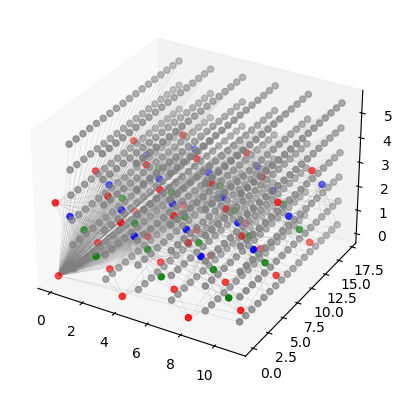

In [24]:
plt.figure(figsize=(20,15))
    
pl=nx.get_node_attributes(code.T,'pos')
lbls_nodes = nx.get_node_attributes(code.T, 'label')


fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')


data_nodes = np.array([pl[node] for node in sorted(code.T) if node < 0])
check_nodes_R = np.array([pl[node] for node in sorted(code.R_nodes) if node >-1])
check_nodes_G = np.array([pl[node] for node in sorted(code.G_nodes) if node >-1])
check_nodes_B = np.array([pl[node] for node in sorted(code.B_nodes) if node >-1])
ax.scatter(*check_nodes_R.T, color = 'red')
ax.scatter(*check_nodes_G.T, color = 'green')
ax.scatter(*check_nodes_B.T, color = 'blue')
ax.scatter(*data_nodes.T, color = 'grey')
ax.grid(False)

edge_xyz = np.array([(code.T.nodes[u]['pos'], code.T.nodes[v]['pos'])for u, v in code.T.edges()])

for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray", linewidth = .1)

plt.show()

### Now let's make the decoder:

In [8]:
def interior(code, W):
    "Determine interior of vertex subset W of Tanner graph T."
    IntW = set()
    for v in W:
        if set(nx.neighbors(code.T,v)).issubset(W):
            IntW.add(v)
    return IntW


def solvable_system(A,b):
    "Determines if there is a solution to Ax=b."
    A_rank = np.linalg.matrix_rank(A)

    # create augmented matrix
    Ab = np.hstack((A, np.atleast_2d(b).T))

    # Must be true for solutions to be consistent
    return A_rank == np.linalg.matrix_rank(Ab)

def solve_underdetermined_system(A, b):
    "Returns a random solution to Ax=b."
    n_vars = A.shape[1]
    A_rank = np.linalg.matrix_rank(A)

    # create augmented matrix
    Ab = np.hstack((A, np.atleast_2d(b).T))

    # Must be true for solutions to be consistent
    if A_rank != np.linalg.matrix_rank(Ab):
        raise Exception("No solution exists.")

    # reduce the system
    Abrr = Ab.row_reduce()

    # additionally need form in which the identity
    # is moved all the way to the left. Do some
    # column swaps to achieve this.
    swaps = []
    for i in range(min(Abrr.shape)):
        if Abrr[i,i] == 0:
            for j in range(i+1,n_vars):
                if Abrr[i,j] == 1:
                    Abrr[:, [i,j]] = Abrr[:, [j,i]]
                    swaps.append((i,j))
                    break

    # randomly generate some independent variables
    n_ind = n_vars - A_rank
    ind_vars = GF(np.zeros(n_ind,dtype = int))
    #ind_vars = np.zeros(n_ind,dtype = int)

    # compute dependent variables using reduced system and dep vars
    dep_vars = -Abrr[:A_rank,A_rank:n_vars]@ind_vars + Abrr[:A_rank,-1]

    # x is just concatenation of the two
    x = np.hstack((dep_vars, ind_vars))

    # swap the entries of x according to the column swaps earlier
    # to get the solution to the original system.
    for s in reversed(swaps):
        x[s[0]], x[s[1]] = x[s[1]], x[s[0]]

    return x


def is_valid_cluster(code, syndrome, cluster):
    "Given a syndrome and cluster, determines if is is valid."

    cluster_interior = interior(code, cluster)

    data_qubits_in_interior = sorted([-i-1 for i in cluster_interior if i<0])
    check_qubits_in_cluster = sorted([i for i in cluster if i>=0])

    GF = galois.GF(code.q)
    A = GF(code.H[check_qubits_in_cluster][:,data_qubits_in_interior])
    b = GF([syndrome[i] for i in check_qubits_in_cluster])

    solved = solvable_system(A,b)

    return solved


def find_valid_correction(code, syndrome, cluster):

    cluster_interior = interior(code, cluster)

    data_qubits_in_interior = sorted([-i-1 for i in cluster_interior if i<0])
    check_qubits_in_cluster = sorted([i for i in cluster if i>=0])

    GF = galois.GF(code.q)
    A = GF(code.H[check_qubits_in_cluster][:,data_qubits_in_interior])
    b = GF([syndrome[i] for i in check_qubits_in_cluster]) 

    sol = solve_underdetermined_system(A,b)

    return sol, data_qubits_in_interior


def cluster_neighbors(code, cluster):
    nbrs = set()
    for v in cluster:
        nbrs.update(set(nx.neighbors(code.T,v)))
    return nbrs

def grow_cluster_nhood(code, cluster: set, n): #grows cluster by another layer of check qubits
    for rounds in range(n):
        cluster.update(cluster_neighbors(code,cluster))
        cluster.update(cluster_neighbors(code,cluster))

    return cluster

In [9]:
def my_HC_decoder(code, error):
    GF = galois.GF(code.q)

    n = len(code.data_nodes)
    syndrome_update = GF(code.H) @ GF(error) 
    e_estimate = GF(np.array([0]*n, dtype=int))


    cluster_size = 1
    n_loop_counter=0
    while True:
        e_estimate_temp = GF(np.array([0]*n, dtype=int))


        n_loop_counter+=1
        #print(f'starting round {n_loop_counter}')
        
        K = [grow_cluster_nhood(code, set([i]), cluster_size) for i,s in enumerate(syndrome_update) if s!=0]
        #print(f'there are {len(K)} clusters')
        
        # now see if merging helps

        merged_to_delete = set()
        for i,Ki in enumerate(K):
            for j,Kj in enumerate(K):
                if j < i and (not Ki.isdisjoint(Kj)):
                    Kj.update(Ki)
                    merged_to_delete.update([i])
                        
                elif j > i and (not Ki.isdisjoint(Kj)):
                    Ki.update(Kj)
                    merged_to_delete.update([j])
                        

        for i in reversed(sorted(merged_to_delete)):
            K.pop(i)

        
        #print('==============================')
        #print(f'there are {len(K)} clusters after merging')
        #repeat about for the above for merged clusters
        for i, Ki in enumerate(K):
            if is_valid_cluster(code, syndrome_update, Ki):
                correction, correction_data_qubits = find_valid_correction(code, syndrome_update, Ki)
                e_estimate_temp[correction_data_qubits] += correction


        syndrome_update -= GF(code.H) @ e_estimate_temp
        e_estimate += e_estimate_temp
        
        if np.array(syndrome_update).sum() ==0:
            break
        
        #infinite loop failsafe
        if n_loop_counter> 20:
            print('infinite loop, something wrong')
            break
        
        # grow size of clustering
        cluster_size+=1


        
    return np.array(e_estimate), syndrome_update #return np.array(error) so that it plays nice with non-Galois stuff

# Now let's test the decoder
* At this stage we havent fixed error model

In [10]:
from pymatching import Matching

In [31]:
code1 = HC_code(5,5,2)
code1.make_tanner_graph()
code1.make_H()
code1.logicals()
GF = galois.GF(code1.q)

matching = Matching(code1.H)

In [32]:
 counter = 0
 for _ in range(10**3):   
    
    code1.make_error(.01)
    code1.E

    predicted_error = matching.decode((code1.H @ code1.E) % 2)
    code1.final_pauli(code1.E-predicted_error)

    if code1.error_XZ.reshape(-1,) @ code1.L1v.reshape(-1,) %2 !=0:
        counter +=1

print(1-counter/10**3)

0.528


In [29]:
counter

446

In [22]:
code1.final_pauli(code1.E-predicted_error)
code1.error_XZ

array([[1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0]])

In [33]:
from joblib import Parallel, delayed

In [34]:
def sim_code(code,p):
    commutator = lambda a,b: (a[0] @ b[0] - a[1]@b[1]) % code.q
    
    counter = 0
    code.make_error(p, meas=False)
    code.final_pauli(my_HC_decoder(code,code.E)[0])

    if commutator(code.L1v, code.error_XZ) != 0: # or commutator(code.L1h, code.error_XZ) !=0: 
        counter +=1

    return counter

In [35]:
p_list = [.002, .005, .01, .015]
runs = 3*10**4

N_list = [3,4]

In [36]:
threshold_list = {}

for N in N_list:    
    code1 = HC_code(N,N,2)
    code1.make_tanner_graph()
    code1.make_H()
    code1.logicals()
    GF = galois.GF(code1.q)

    threshold_list[N] = []
    for p in p_list:
        sim_p = lambda : sim_code(code1, p)

        sim_array = np.array(Parallel(n_jobs=-1)(delayed(sim_p)() for n in list(range(runs))))

        threshold_list[N].append(1-sim_array.sum()/runs)

    print(threshold_list[N])

[0.9973666666666666, 0.9825666666666667, 0.9275333333333333, 0.8428]
[0.9991, 0.9879, 0.9071, 0.7566333333333333]


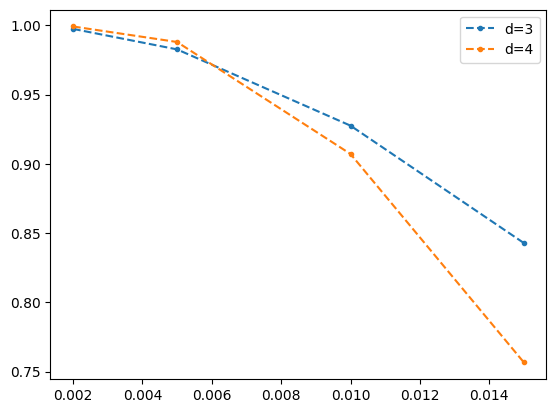

In [38]:
for N in N_list:

    plt.plot(p_list, threshold_list[N], '.--', label = f'd={N}')


plt.legend()

### 1. Need way to convert error + correction to an error string on top layer:
### 2. Need error model function

### Lets test a single system size to see step function shape